# Glassdoor comments analysis
This large dataset contains job descriptions and rankings among various criteria such as work-life balance, income, culture, etc. The data covers the various industries in the UK. Great dataset for multidimensional sentiment analysis.

link: https://www.kaggle.com/datasets/davidgauthier/glassdoor-job-reviews

Ranking for the recommendation of the firm, CEO approval, and outlook are allocated categories v, r, x, and o, with the following meanings:
+ v - Positive
+ r - Mild
+ x - Negative
+ o - No opinion

I will start setting up the environment by adding the /src/ path.

In [1]:
import os
import sys

src_path = os.path.abspath('../src')
if src_path not in sys.path:
    sys.path.append(src_path)
    print('Path added to system.')
else:
    print('Requirement previously satisfied.')

Path added to system.


In [2]:
from preprocessing import *

In [3]:
df = load_dataset()
df.info()

Dataset found: ../data/glassdoor_reviews.csv
Dataset is loaded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838566 entries, 0 to 838565
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   firm                 838566 non-null  object 
 1   date_review          838566 non-null  object 
 2   job_title            838566 non-null  object 
 3   current              838566 non-null  object 
 4   location             541223 non-null  object 
 5   overall_rating       838566 non-null  int64  
 6   work_life_balance    688672 non-null  float64
 7   culture_values       647193 non-null  float64
 8   diversity_inclusion  136066 non-null  float64
 9   career_opp           691065 non-null  float64
 10  comp_benefits        688484 non-null  float64
 11  senior_mgmt          682690 non-null  float64
 12  recommend            838566 non-null  object 
 13  ceo_approv           838566 non-null  object 
 14  outl

___
Some interesting data has Nulls:
+ overall_rating
+ recommend
+ headline
+ pros
+ cons

The rows containing Nulls will be removed.

In [4]:
columns = ['overall_rating', 'recommend', 'headline', 'pros', 'cons']
df = remove_empty_rows(df, columns)
df.info()

Rows with empty values were removed from selected columns.
<class 'pandas.core.frame.DataFrame'>
Index: 835961 entries, 0 to 838565
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   firm                 835961 non-null  object 
 1   date_review          835961 non-null  object 
 2   job_title            835961 non-null  object 
 3   current              835961 non-null  object 
 4   location             539356 non-null  object 
 5   overall_rating       835961 non-null  int64  
 6   work_life_balance    687174 non-null  float64
 7   culture_values       645801 non-null  float64
 8   diversity_inclusion  135326 non-null  float64
 9   career_opp           689551 non-null  float64
 10  comp_benefits        686986 non-null  float64
 11  senior_mgmt          681205 non-null  float64
 12  recommend            835961 non-null  object 
 13  ceo_approv           835961 non-null  object 
 14  outlook       

___
The relationship between the column **overall_rating** and **recommend** will be analyzed using a contigency table and a heat map. It is required to map the **recommend** variable to numeric values as follows:
+ v - Positive = +2
+ r - Mild = +1
+ x - Negative = -2
+ o - No opinion = 0

In [5]:
columns_to_map = ['recommend']
df_mapped, name_columns_mapped = rank_mapping(df = df,
											columns = columns_to_map)

Mapping to numeric values for recommend column.
Column mapped.


___
Lets see the distribution of the new column **recommend_level**.

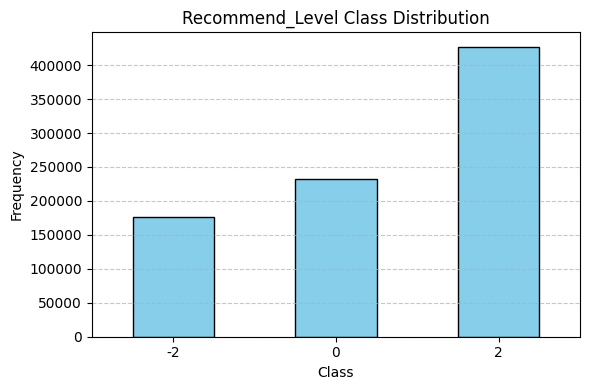

In [6]:
import matplotlib.pyplot as plt

def bar_distribution_plot(df, column:str=None):
    class_counts = df[column].value_counts().sort_index()
    plt.figure(figsize=(6, 4))
    class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'{column.title()} Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

bar_distribution_plot(df_mapped, 'recommend_level')

___
Unfortunately, the column **recommend_level** which is the target (at least in this first approach) is unbalanced.

Now, lets see if the column **overall_rating** has a relationship with the column **recommend_level**. To analyze this, a contingency table with heat map will be presented.

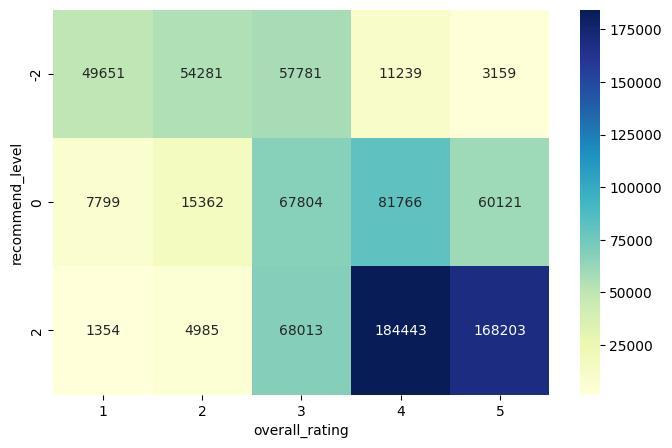

In [7]:
import seaborn as sns

contigency_table = pd.crosstab(df_mapped[name_columns_mapped[0]], df_mapped['overall_rating'])

plt.figure(figsize=(8,5))
sns.heatmap(contigency_table, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

___
It exists a relatinship between **recommend** and **overall_rating**.

But, the value **o** from **recommend** column is useless due to its meaning is *no opinion*. It is not possible to know if there is a positive, negative or neutral opinion. So, the data with **o** value will be removed.

In [8]:
df_mapped = df_mapped[df_mapped['recommend'] != 'o']
print(df_mapped['recommend'].value_counts())
print('\n')
print(df_mapped.info())

recommend
v    426998
x    176111
Name: count, dtype: int64


<class 'pandas.core.frame.DataFrame'>
Index: 603109 entries, 0 to 838565
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   firm                 603109 non-null  object 
 1   date_review          603109 non-null  object 
 2   job_title            603109 non-null  object 
 3   current              603109 non-null  object 
 4   location             432171 non-null  object 
 5   overall_rating       603109 non-null  int64  
 6   work_life_balance    583730 non-null  float64
 7   culture_values       554779 non-null  float64
 8   diversity_inclusion  110851 non-null  float64
 9   career_opp           583462 non-null  float64
 10  comp_benefits        583188 non-null  float64
 11  senior_mgmt          580431 non-null  float64
 12  recommend            603109 non-null  object 
 13  ceo_approv           603109 non-null  object 
 14  outlook    

___
Now, lets clean the current data.
The objective is to remove the next information for the *corpus* columns (headline, pros, cons):
+ Capital letters.
+ Numbers in text.
+ Puntuation marks.
+ Extra spaces.

In [9]:
columns = ['headline', 'pros', 'cons']
df_cleaned, name_columns_cleaned = cleanning(df=df_mapped,
                                            columns=columns,
                                            lower_case=True,
                                            remove_numbers=True,
                                            remove_punctuation=True,
                                            remove_extra_spaces=True)

df_cleaned[name_columns_cleaned].head()

Cleaning process for headline.
Capital letters removed.
Numbers in text removed.
Punctuation removed.
Extra spaces removed.
Cleaning process for pros.
Capital letters removed.


/Users/albertosantosmorales/Documents/UdG_MCD/semestre_2/programacion_2/progra2_mcd_challenges/comments_on_glassdoor_challenge/src/preprocessing.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_names[-1]] = series


Numbers in text removed.
Punctuation removed.
Extra spaces removed.
Cleaning process for cons.
Capital letters removed.


/Users/albertosantosmorales/Documents/UdG_MCD/semestre_2/programacion_2/progra2_mcd_challenges/comments_on_glassdoor_challenge/src/preprocessing.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_names[-1]] = series


Numbers in text removed.
Punctuation removed.
Extra spaces removed.


/Users/albertosantosmorales/Documents/UdG_MCD/semestre_2/programacion_2/progra2_mcd_challenges/comments_on_glassdoor_challenge/src/preprocessing.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_names[-1]] = series


,headline_cleaned,pros_cleaned,cons_cleaned
0,young colleagues poor micro management,very friendly and welcoming to new staff easy ...,poor salaries poor training and communication
1,excellent staff poor salary,friendly helpful and hardworking colleagues,poor salary which doesnt improve much with pro...
2,low salary bad micromanagement,easy to get the job even without experience in...,very low salary poor working conditions very l...
3,over promised under delivered,nice staff to work with,no career progression and salary is poor
4,client reporting admin,easy to get the job nice colleagues,abysmal pay around minimum wage no actual trai...


___
The next objective is to remove:
+ Stop words (like: The, a, in, etc.).
+ Lemmatize.
+ Merge *headline*, *pros* and *cons* columns.

In [10]:
df_no_stopwords, name_columns_no_stopwords = stopwords_remotion(df = df_cleaned,
																columns = name_columns_cleaned) 
	
df_lemmatized, name_columns_lemmatized = lemmatizing(df = df_no_stopwords,
													columns = name_columns_no_stopwords)

df_text_merged, name_merged_column = text_columns_merging(df = df_lemmatized,
														columns=name_columns_lemmatized)

df_text_merged[name_merged_column].head()

Stop words remotion process for headline_cleaned.


/Users/albertosantosmorales/Documents/UdG_MCD/semestre_2/programacion_2/progra2_mcd_challenges/comments_on_glassdoor_challenge/src/preprocessing.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_names[-1]] = series


Stop words removed.
Stop words remotion process for pros_cleaned.


/Users/albertosantosmorales/Documents/UdG_MCD/semestre_2/programacion_2/progra2_mcd_challenges/comments_on_glassdoor_challenge/src/preprocessing.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_names[-1]] = series


Stop words removed.
Stop words remotion process for cons_cleaned.


/Users/albertosantosmorales/Documents/UdG_MCD/semestre_2/programacion_2/progra2_mcd_challenges/comments_on_glassdoor_challenge/src/preprocessing.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_names[-1]] = series


Stop words removed.
Lemmatizing process for headline_cleaned_no_stopwords.


/Users/albertosantosmorales/Documents/UdG_MCD/semestre_2/programacion_2/progra2_mcd_challenges/comments_on_glassdoor_challenge/src/preprocessing.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_names[-1]] = series


Text lemmatized.
Lemmatizing process for pros_cleaned_no_stopwords.


/Users/albertosantosmorales/Documents/UdG_MCD/semestre_2/programacion_2/progra2_mcd_challenges/comments_on_glassdoor_challenge/src/preprocessing.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_names[-1]] = series


Text lemmatized.
Lemmatizing process for cons_cleaned_no_stopwords.


/Users/albertosantosmorales/Documents/UdG_MCD/semestre_2/programacion_2/progra2_mcd_challenges/comments_on_glassdoor_challenge/src/preprocessing.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_names[-1]] = series


Text lemmatized.
Columns ['headline_cleaned_no_stopwords_lemmatized', 'pros_cleaned_no_stopwords_lemmatized', 'cons_cleaned_no_stopwords_lemmatized'] merged.


/Users/albertosantosmorales/Documents/UdG_MCD/semestre_2/programacion_2/progra2_mcd_challenges/comments_on_glassdoor_challenge/src/preprocessing.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name_of_column] = df[columns].fillna('').agg(' '.join, axis=1)


0    young colleague poor micro management friendly...
1    excellent staff poor salary friendly helpful h...
2    low salary bad micromanagement easy get job ev...
3    promised delivered nice staff work career prog...
4    client reporting admin easy get job nice colle...
Name: text_merged_column, dtype: object

___
The next step is to vectorize the *corpus* using the TFIDF method. The output sparse matrix will be the **X** for the model.
Then the **y** definition is performed and the split for training and testing subsets is carried out. 

In [11]:
from model_training import *

X = tfidf_vectorizing(df_text_merged[name_merged_column])
X

Text vectorized


<603109x140909 sparse matrix of type '<class 'numpy.float64'>'
	with 14148168 stored elements in Compressed Sparse Row format>

In [12]:
y = df_text_merged['recommend_level']

X_train, X_test, y_train, y_test = get_train_test_subsets(X=X, y=y)

Feature subset for training was built. 422176 samples
Feature subset for testing was built. 180933 samples
Target subset for training was built. 422176 samples
Target subset for testing was built. 180933 samples


___
Now, the training needs to be done.
As first approach I will use a Logistic Regression model, specifiying that my dataset is unbalanced.

In [13]:
from sklearn.linear_model import LogisticRegression

model = model_training(model = LogisticRegression(class_weight='balanced', max_iter=1000),
						X_train = X_train,
						y_train = y_train)
model

Model "LogisticRegression" trained.


LogisticRegression(class_weight='balanced', max_iter=1000)

In [14]:
from evaluation import model_predictions, model_evaluation

y_pred, y_prob = model_predictions(model = model, 
									X_test = X_test,
									prob = True)

Model predictions done.
Model probabilistic predictions done.


Model accurracy: 80.46%
Model F1 score: 0.778
Confusion matrix plotted.
Model AUC score: 0.8808
ROC plotted.


/Users/albertosantosmorales/Documents/UdG_MCD/semestre_2/programacion_2/progra2_mcd_challenges/comments_on_glassdoor_challenge/src/evaluation.py:81: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


({'accurracy': 0.8046127572084695,
  'f1_score': np.float64(0.7779710032302533),
  'auc_score': np.float64(0.8807781541648936)},
 {'confusion_matrix': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x3492b2f30>,
  'roc': <Figure size 640x480 with 1 Axes>})

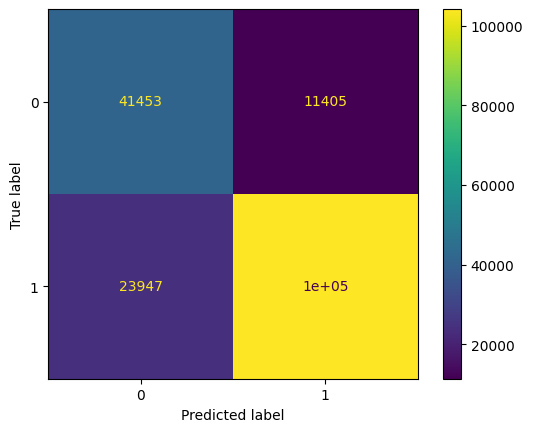

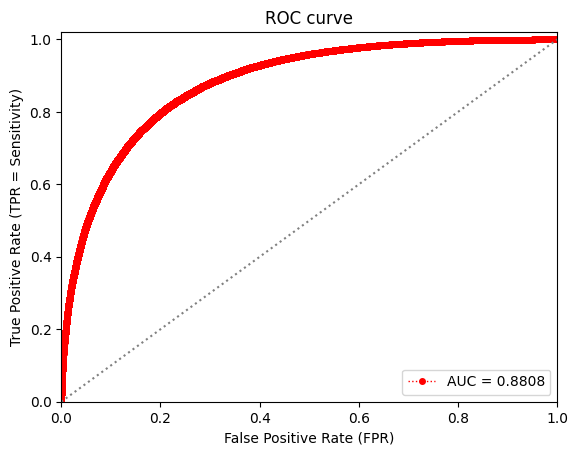

In [15]:
model_evaluation(y_pred, y_prob, y_test)

___
## Conclusion
For this first approach using Logistic Regression I got interesting metrics (see report above). I feel uncomfortable because I removed important data from the *corpus* due to *no-opinion* label into **recommend** variable.
That is the reason I would like to try a second approach using Linear Regression and the variable **overall_rating**.

## Second approach. Linear Regression 

In [16]:
df = load_dataset()
columns = ['overall_rating', 'headline', 'pros', 'cons']
df = remove_empty_rows(df, columns)
df.info()

Dataset found: ../data/glassdoor_reviews.csv
Dataset is loaded.
Rows with empty values were removed from selected columns.
<class 'pandas.core.frame.DataFrame'>
Index: 835961 entries, 0 to 838565
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   firm                 835961 non-null  object 
 1   date_review          835961 non-null  object 
 2   job_title            835961 non-null  object 
 3   current              835961 non-null  object 
 4   location             539356 non-null  object 
 5   overall_rating       835961 non-null  int64  
 6   work_life_balance    687174 non-null  float64
 7   culture_values       645801 non-null  float64
 8   diversity_inclusion  135326 non-null  float64
 9   career_opp           689551 non-null  float64
 10  comp_benefits        686986 non-null  float64
 11  senior_mgmt          681205 non-null  float64
 12  recommend            835961 non-null  object 
 13  c

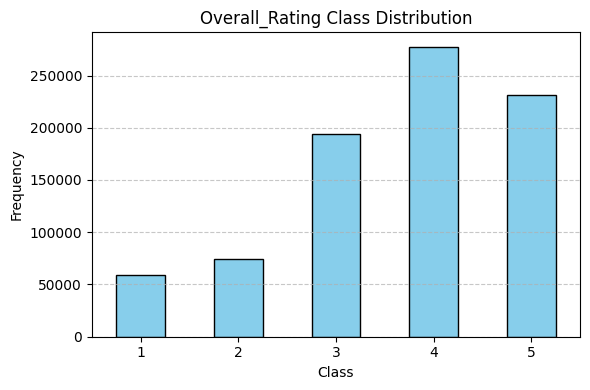

In [17]:
bar_distribution_plot(df, 'overall_rating')

___
Once again, we can see the target variable has unbalanced samples.

In [18]:
columns = ['headline', 'pros', 'cons']
df_cleaned, name_columns_cleaned = cleanning(df=df_mapped,
                                            columns=columns,
                                            lower_case=True,
                                            remove_numbers=True,
                                            remove_punctuation=True,
                                            remove_extra_spaces=True)

df_no_stopwords, name_columns_no_stopwords = stopwords_remotion(df = df_cleaned,
																columns = name_columns_cleaned) 
	
df_lemmatized, name_columns_lemmatized = lemmatizing(df = df_no_stopwords,
													columns = name_columns_no_stopwords)

df_text_merged, name_merged_column = text_columns_merging(df = df_lemmatized,
														columns=name_columns_lemmatized)

X = tfidf_vectorizing(df_text_merged[name_merged_column])
y = df_text_merged['overall_rating']

X_train, X_test, y_train, y_test = get_train_test_subsets(X=X, y=y)

Cleaning process for headline.
Capital letters removed.
Numbers in text removed.
Punctuation removed.
Extra spaces removed.
Cleaning process for pros.
Capital letters removed.
Numbers in text removed.
Punctuation removed.
Extra spaces removed.
Cleaning process for cons.
Capital letters removed.
Numbers in text removed.
Punctuation removed.
Extra spaces removed.
Stop words remotion process for headline_cleaned.
Stop words removed.
Stop words remotion process for pros_cleaned.
Stop words removed.
Stop words remotion process for cons_cleaned.
Stop words removed.
Lemmatizing process for headline_cleaned_no_stopwords.
Text lemmatized.
Lemmatizing process for pros_cleaned_no_stopwords.
Text lemmatized.
Lemmatizing process for cons_cleaned_no_stopwords.
Text lemmatized.
Columns ['headline_cleaned_no_stopwords_lemmatized', 'pros_cleaned_no_stopwords_lemmatized', 'cons_cleaned_no_stopwords_lemmatized'] merged.
Text vectorized
Feature subset for training was built. 422176 samples
Feature subset 

In [19]:
from sklearn.linear_model import LinearRegression

model = model_training(model = LinearRegression(),
						X_train = X_train,
						y_train = y_train)
model

Model "LinearRegression" trained.


LinearRegression()

In [20]:
y_pred = model_predictions(model = model, 
							X_test = X_test)

Model predictions done.


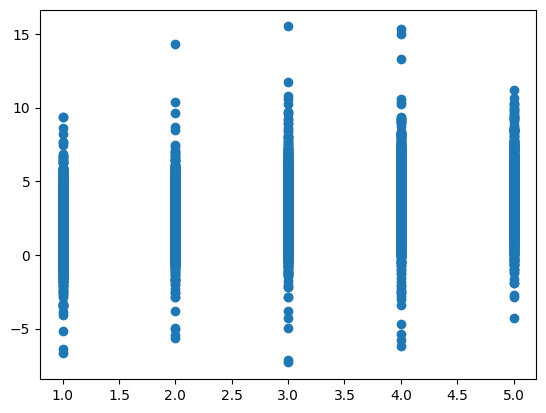

In [23]:
plt.scatter(y_test, y_pred)
plt.show()

In [26]:
from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE = {round(rmse, 4)}')
print(f'r2 = {round(r2, 4)}')

RMSE = 0.9693
r2 = 0.3756


___
From the plot (y_test vs y_pred) we can see that y_pred has values from about -7 to +15. We need to overcome this behaviour in the next cell.
The metrics are not good. More work is required.

In [28]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred_clipped = np.clip(np.round(y_pred), 1, 5).astype(int)

print(classification_report(y_test, y_pred_clipped))
print(confusion_matrix(y_test, y_pred_clipped))

              precision    recall  f1-score   support

           1       0.62      0.24      0.34     15280
           2       0.31      0.27      0.29     17739
           3       0.35      0.44      0.39     37687
           4       0.43      0.63      0.51     58845
           5       0.65      0.34      0.45     51382

    accuracy                           0.44    180933
   macro avg       0.47      0.38      0.40    180933
weighted avg       0.48      0.44      0.43    180933

[[ 3628  5402  4816  1285   149]
 [ 1270  4773  8195  3242   259]
 [  563  3368 16470 15836  1450]
 [  255  1205 12517 37293  7575]
 [  141   444  4539 28659 17599]]


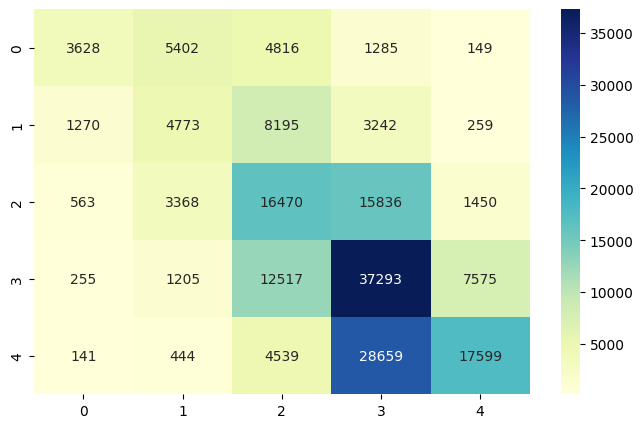

In [29]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred_clipped), annot=True, fmt='d', cmap='YlGnBu')
plt.show()

___
After the adjustment done two cells above the model behavior still having deficiencies. So, I will keep the Logistic Regression and move with the next assignments.